# 1. Introduction

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Objectives</b></p>
</div>

In this notebook we'll be building a **Gaussian Mixture Model** (GMM), **Poisson Mixture Model** (PMM) and a **Hybrid Mixture Model** (HMM) from scratch. We'll use the **Expectation-Maximisation** (EM) algorithm to learn the parameters of these models.

**Note:** There is very **little information about PMMs** online and it seems they haven't been studied much before. As a result, a lot of the equations in this notebook have been derived by myself; some rigorously and others using only my intuition of EM. I am also quite confident that there will be more efficient implementations of these models. If you have any ideas for improvements please share your feedback. 

My other [notebook on GMMs](https://www.kaggle.com/code/samuelcortinhas/gaussian-mixture-model-gmm-from-the-ground-up) goes into more detail of how the EM algorithm works, so feel free to read that one before this one.

**TL;DR:** The data for this competition isn't modelled well by PMM or HMM but the code can still be used for other problems.

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.2 Libraries</b></p>
</div>

In [1]:
# Core
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from itertools import combinations
import math
import statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import chi2
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import norm
import time
from datetime import datetime
import matplotlib.dates as mdates
import plotly.express as px
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# UMAP
import umap
import umap.plot

# 2. Gaussian Mixture Model

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 Gaussian Mixture</b></p>
</div>

A **Gaussian Mixture** is simply a combination (or mixture) of Gaussian distributions. In **d dimensions**, the model is a weighted sum of **multivariate** normal distributions:

$$
f_{\text{GMM}} (\textbf{x}) = \sum_{j=1}^{k} \pi_j f_{\mathcal{N}({\boldsymbol \mu}_j, {\boldsymbol \Sigma}_{j})} (\textbf{x})
$$

where

* $\textbf{x} = (x_1, \ldots, x_d)$ is a vector of length $d$
* $f_{\mathcal{N}({\boldsymbol \mu}_j, {\boldsymbol \Sigma}_{j})}$ is the density of a **multivariate** normal distribution with mean vector ${\boldsymbol \mu}$ and covariance matrix ${\boldsymbol \Sigma}$
* $\pi = (\pi_1, \ldots, \pi_k)$ are the weights subject to

$$
0 \leq \pi_j \leq 1, \quad \sum_{j=1}^{k} \pi_j = 1.
$$

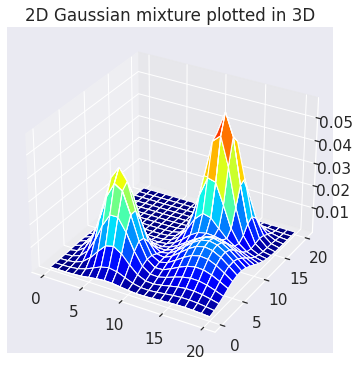

In [2]:
# Define grid
x = np.linspace(0,20, num=100).astype(int)
y = np.linspace(0,20, num=100).astype(int)
x, y = np.meshgrid(x, y)

# Calculate pdf over mesh
z1 = multivariate_normal.pdf(np.dstack((x, y)), [6,5], [[4,1],[-1,4]])
z2 = multivariate_normal.pdf(np.dstack((x, y)), [14,14], [[3,1],[1,3]])
z3 = multivariate_normal.pdf(np.dstack((x, y)), [16,7], [[10,1],[-1,10]])
z = z1 + z2 + z3

# Plot 3D plot with gaussian mixture
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z, cmap=cm.jet)
ax.set_title('2D Gaussian mixture plotted in 3D')
plt.show()

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.2 EM algorithm for the GMM</b></p>
</div>


## Initialisation

For each cluster $j$, choose the **mean** ${\boldsymbol \mu}_j$ to be a **random data point** and the **covariance** ${\boldsymbol \Sigma}_j$ to be the **covariance of the whole dataset** $X$. The **weights** $\pi = (\pi_1, \ldots, \pi_k)$ are initially **uniform**.

## E-step

We update the **responsibilities** (i.e. posterior probabilities) using Bayes' formula, where $r_{ij}$ is the probability that the $i$-th data point belongs to the $j$-th mixture

$$
r_{ij} = \mathbb{P}(C_j | \textbf{x}_i) = \frac{\mathbb{P}(\textbf{x}_i|C_j) \mathbb{P}(C_j)}{\sum_{t=1}^{k} \mathbb{P}(\textbf{x}_i|C_t) \mathbb{P}(C_t)} = \frac{\mathbb{P}(\textbf{x}_i|C_j) \pi_j}{\sum_{t=1}^{k} \mathbb{P}(\textbf{x}_i|C_t) \pi_t}
$$

where the **likelihoods** are Gaussian densities

$$
\mathbb{P}(\textbf{x}_i | C_j) = \frac{1}{\sqrt{(2 \pi)^d \det({\boldsymbol \Sigma}_j)}} \exp \left(-\frac{(\textbf{x}_i-{\boldsymbol \mu}_j)^T {\boldsymbol \Sigma}_j^{-1} (\textbf{x}_i-{\boldsymbol \mu}_j)}{2} \right)
$$

## M-step

We estimate the **mean** and **covariances** of each class as follows

$$
{\boldsymbol \mu}_j = \frac{\sum_{i=1}^n r_{ij} \textbf{x}_{i}}{n_j}, \qquad {\boldsymbol \Sigma}_j = \frac{1}{n_j} \sum_{i=1}^{n} r_{ij} (\textbf{x}_i - {\boldsymbol \mu}_j) (\textbf{x}_i - {\boldsymbol \mu}_j)^{T}
$$

where $n_j = \sum_{i=1}^{n} r_{ij}$ is defined as the **total responsibility** of the j-th mixture component.

The **mixture weights** are updated via

$$
\pi_j = \frac{n_j}{n}.
$$

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.3 GMM implementation</b></p>
</div>

In [3]:
class GMM:
    def __init__(self, k, max_iter=100, random_state = 0):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state

    def initialise(self, X):
        self.shape = X.shape
        self.n, self.d = self.shape
        
        self.pi = np.full(shape=self.k, fill_value=1/self.k)
        self.responsibilities = np.full(shape=self.shape, fill_value=1/self.k)
        
        np.random.seed(self.random_state)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]

    def E_step(self, X):
        # E-Step: update the responsibilities by holding mu and sigma constant
        self.responsibilities = self.predict_proba(X)
    
    def M_step(self, X):
        # M-Step: update pi, mu and sigma by holding responsibilities constant
        self.pi = self.responsibilities.mean(axis=0)
        for j in range(self.k):
            r_column = self.responsibilities[:,j]
            total_responsibility = r_column.sum()
            self.mu[j] = (X * r_column[:, np.newaxis]).sum(axis=0)/total_responsibility
            self.sigma[j] = np.cov(X.T, aweights=(r_column/total_responsibility).flatten(), bias=True)

    def fit(self, X):
        self.initialise(X)
        
        for iteration in range(self.max_iter):
            self.E_step(X)
            self.M_step(X)
    
    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for j in range(self.k):
            distribution = multivariate_normal(mean=self.mu[j], cov=self.sigma[j])
            likelihood[:,j] = distribution.pdf(X)
        
        numerator = likelihood * self.pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        responsibilities = numerator / denominator
        return responsibilities
    
    def predict(self, X):
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        predictions = self.predict(X)
        return predictions

# 3. Poisson Mixture Model

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.1 Poisson Mixture</b></p>
</div>

A **Poisson Mixture** is a mixture of Poisson distributions. In **d dimensions**, the model is a weighted sum of **multivariate** Poisson distributions:

$$
f_{\text{PMM}} (\textbf{x}) = \sum_{j=1}^{k} \pi_j f_{\text{PoM}({\boldsymbol \Lambda}_j)} (\textbf{x})
$$

where the d-dimensional **multivariate Poisson distribution** corresponds to the **discrete** [distribution](https://reference.wolfram.com/language/ref/MultivariatePoissonDistribution.html#:~:text=The%20multivariate%20Poisson%20distribution%20is,and%20covariance%20of%20the%20distribution.)

$$
(X_0 + X_1, X_0 + X_2, \ldots, X_0 + X_d)
$$

with

$$
X_i \sim \text{Po}(\lambda_j).
$$

<hr>

Recall that $X \sim \text{Po}(\lambda)$ means that

$$
\mathbb{P}(X=k) = \frac{e^{-\lambda} \lambda^{k}}{k!}
$$

<hr>

We start by deriving the **probability mass function** of the multivariate poisson distribution. This will be our **likelihood** in the EM algorithm. 

Notice that the event $(X_0 + X_1, X_0 + X_2, \ldots, X_0 + X_d) = (x_1, x_2, \ldots, x_d)$ is the **disjoint union** of the events $(X_0, X_1, \ldots, X_d) = (i, x_1 - i, x_2 -i, \ldots, x_d - i)$.

This means we can **sum** over the probabilities that are well defined, which happens when $i \leq \min(x_1, x_2, \ldots, x_d)$, otherwise the values would be negative. This gives

$$
\begin{align*}
f_{\text{PoM}({\boldsymbol \Lambda})} (\textbf{x}) &= \sum_{i=0}^{\min(x_1, \ldots, x_d)} \mathbb{P}(X_0 = i) \mathbb{P}(X_1 = x_1-i) \ldots \mathbb{P}(X_d = x_d -i) \newline
& = \sum_{i=0}^{\min(x_1, \ldots, x_d)} \left(\frac{e^{-\lambda_0} \lambda_0^{i}}{i!} \right) \left(\frac{e^{-\lambda_1} \lambda_1^{(x_1 - i)}}{(x_1 - i)!} \right) \ldots \left(\frac{e^{-\lambda_d} \lambda_d^{(x_d - i)}}{(x_d - i)!} \right) \newline
&= e^{-(\lambda_0 + \ldots + \lambda_d)} \sum_{i=0}^{\min(x_1, \ldots, x_d)} \frac{\lambda_0^{i}}{i!} \frac{\lambda_1^{(x_1 - i)}}{(x_1 - i)!} \ldots \frac{\lambda_d^{(x_d - i)}}{(x_d - i)!}
\end{align*}
$$

(I think that's the simplest form.)


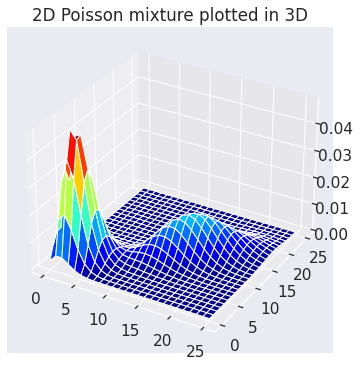

In [4]:
# Define grid
x = np.linspace(0,25, num=26).astype(int)
y = np.linspace(0,25, num=26).astype(int)
x, y = np.meshgrid(x, y)
z = 0

# Calculate pmf
def multivariate_poisson(X, Y, mu0, mu1, mu2):
    exponent = np.exp(-(mu0+mu1+mu2))
    out = np.zeros(X.shape)
    for p in range(len(X)):
        for q in range(len(X)):
            x = X[p,q]
            y = Y[p,q]
            minimum = np.min((x,y))
            term=0
            for i in range(minimum+1):
                powers = np.array([i, x-i, y-i])
                term += np.prod(np.power([mu0, mu1, mu2],powers) / factorial(powers, exact=True))
            out[p,q] = exponent * term
    return out

# Evaluate pmf over grid
z1 = multivariate_poisson(x, y, 1, 2, 3)
z2 = multivariate_poisson(x, y, 10, 6, 3)
z = z1 + z2

# Plot 3D plot with gaussian mixture
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z, cmap=cm.jet)
ax.set_title('2D Poisson mixture plotted in 3D')
plt.show()

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.2 EM algorithm for the PMM</b></p>
</div>


## Initialisation

For each cluster $j$, we choose the **vector** $(\lambda_1, \ldots, \lambda_d)$ to be a **random data point** and $\lambda_0$ to be a random interger between 0 and k, which together make up the multivariate **rate** parameter $\Lambda$. The **weights** $\pi = (\pi_1, \ldots, \pi_k)$ are initially **uniform**.

## E-step

We update the **responsibilities** (i.e. posterior probabilities) using Bayes' formula, where $r_{ij}$ is the probability that the $i$-th data point belongs to the $j$-th mixture

$$
r_{ij} = \mathbb{P}(C_j | \textbf{x}_i) = \frac{\mathbb{P}(\textbf{x}_i|C_j) \mathbb{P}(C_j)}{\sum_{t=1}^{k} \mathbb{P}(\textbf{x}_i|C_t) \mathbb{P}(C_t)} = \frac{\mathbb{P}(\textbf{x}_i|C_j) \pi_j}{\sum_{t=1}^{k} \mathbb{P}(\textbf{x}_i|C_t) \pi_t}
$$

where the **likelihoods** are multivariate Poisson densities

$$
\mathbb{P}(C_j | \textbf{x}_i) = e^{-(\lambda_0 + \ldots + \lambda_d)} \sum_{i=0}^{\min(x_1, \ldots, x_d)} \frac{\lambda_0^{i}}{i!} \frac{\lambda_1^{(x_1 - i)}}{(x_1 - i)!} \ldots \frac{\lambda_d^{(x_d - i)}}{(x_d - i)!}
$$

## M-step

We estimate the **mean** and **covariances** of each class as follows

$$
{\boldsymbol \mu}_j = \frac{\sum_{i=1}^n r_{ij} \textbf{x}_{i}}{n_j}, \qquad {\boldsymbol \Sigma}_j = \frac{1}{n_j} \sum_{i=1}^{n} r_{ij} (\textbf{x}_i - {\boldsymbol \mu}_j) (\textbf{x}_i - {\boldsymbol \mu}_j)^{T}
$$

where $n_j = \sum_{i=1}^{n} r_{ij}$ is defined as the **total responsibility** of the j-th mixture component.

<hr>

It is known [theory](https://reference.wolfram.com/language/ref/MultivariatePoissonDistribution.html#:~:text=The%20multivariate%20Poisson%20distribution%20is,and%20covariance%20of%20the%20distribution.) that the **covariance matrix** of the multivariate Poisson distribution has the following form

$$
\left(\begin{array}{cccc}
(\lambda_0 + \lambda_1) & \lambda_0 & \ldots & \lambda_0 \\
\lambda_0 & (\lambda_0 + \lambda_2) & {} & \vdots \\
\vdots & {} & \ddots & \lambda_0 \\
\lambda_0 & \ldots & \lambda_0 & (\lambda_0 + \lambda_d)
\end{array}\right)
$$

In practice, the non-diagonal elements are not all the same because of the noise in the dataset. What I propose, is to **average** all the **non-diagonal** elements to calculate $\lambda_0$, and then to update the Poisson rates via ${\boldsymbol \mu} - \lambda_0 {\boldsymbol 1}$.

<hr>

The **mixture weights** are updated via

$$
\pi_j = \frac{n_j}{n}.
$$

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.3 PMM implementation</b></p>
</div>

In [5]:
class PMM:
    def __init__(self, k, max_iter=10, random_state=0):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state

    def initialise(self, X):
        self.shape = X.shape
        self.n, self.d = self.shape
        
        self.pi = np.full(shape=self.k, fill_value=1/self.k)
        self.responsibilities = np.full(shape=self.shape, fill_value=1/self.k)
        
        np.random.seed(self.random_state)
        lambda0 = np.random.choice(range(self.k), size=self.k, replace = False)
        random_row = np.random.choice(range(self.n), size=self.k, replace = False)
        self.lambd = np.c_[lambda0, np.array([X[row_index,:] for row_index in random_row])]  # shape (k,d+1)
    
    def E_step(self, X):
        # E-Step: update the responsibilities by holding lambda constant
        self.responsibilities = self.predict_proba(X)
    
    def M_step(self, X):
        # M-Step: update pi and lambda by holding responsibilities constant
        self.pi = self.responsibilities.mean(axis=0)
        for j in range(self.k):
            r_column = self.responsibilities[:,j]
            r_column[r_column<0]=0
            total_responsibility = r_column.sum()
            mu = (X * r_column[:, np.newaxis]).sum(axis=0)/total_responsibility
            sigma = np.cov(X.T, aweights=(r_column/total_responsibility).flatten(), bias=True)
            lambda0 = (sigma.sum()-np.diag(sigma).sum())/(self.d**2-self.d) # average non-diagonal elements
            self.lambd[j,:] = np.concatenate(([lambda0], mu-lambda0))
    
    def fit(self, X):
        self.initialise(X)
        
        for iteration in range(self.max_iter):
            self.E_step(X)
            self.M_step(X)
    
    def multivariate_poisson(self, X, cluster):
        exponent = np.exp(-self.lambd[cluster,:].sum())
        probs=[]
        for p in range(self.n):
            x = X[p,:]
            term=0
            for i in range(x.min()+1):
                powers = np.concatenate(([i],[x[q]-i for q in range(self.d)]))
                term += np.prod(np.power(self.lambd[cluster,:],powers)/factorial(powers, exact=True))
            probs.append(exponent * term)
        return probs
    
    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for j in range(self.k):
            likelihood[:,j] = self.multivariate_poisson(X,j)
        
        numerator = likelihood * self.pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        responsibilities = numerator / denominator
        return responsibilities
    
    def predict(self, X):
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        predictions = self.predict(X)
        return predictions

# 4. Hybrid Mixture Model

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 Hybrid Mixture</b></p>
</div>

We define a **Hybrid Mixture** to be the mixture of hybrid distributions. For the purposes of the [July 2022 TPS competition](https://www.kaggle.com/competitions/tabular-playground-series-jul-2022), we define the relevant hybrid distributions to be the **concatenation** of a **multivariate Poisson distribution** with a **multivariate Gaussian distribution**. In particular,

$$
(X, Y)
$$

where

$$
X = (X_0+X_1, X_0+X_2, \ldots, X_0+X_{d_1})
$$

$$
X_i \sim \, \text{Po}(\lambda_i), \quad i=0, \ldots, d_1
$$

and

$$
Y = (Y_1, Y_2, \ldots, Y_{d_2})
$$

$$
Y_i \sim \, \mathcal{N}({\boldsymbol \mu}_i,{\boldsymbol \Sigma}_i), \quad i=1, \ldots, d_2.
$$

<hr>

For $f_{\text{Hyb}} \sim (X,Y)$, our **Hybrid Mixture Model** is 

$$
f_{\text{HMM}} (\textbf{x}, \textbf{y}) = \sum_{j=1}^{k} \pi_j f_{\text{Hyb}({\boldsymbol \Lambda}_j, {\boldsymbol \mu}_j, {\boldsymbol \Sigma}_j)} (\textbf{x}, \textbf{y}) = \sum_{j=1}^{k} \pi_j (f_{\text{PoM}({\boldsymbol \Lambda}_j)} (\textbf{x}), f_{\mathcal{N}({\boldsymbol \mu}_j, {\boldsymbol \Sigma}_j)} (\textbf{y})).
$$

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.2 EM algorithm for the HMM</b></p>
</div>


## Initialisation

For each cluster $j$, we initialise the **Poisson parameters** like in a PMM and the **Gaussian parameters** like in a GMM (see above). The **weights** $\pi = (\pi_1, \ldots, \pi_k)$ are initially **uniform**.

## E-step

We update the **responsibilities** (i.e. posterior probabilities) using Bayes' formula, where $r_{ij}$ is the probability that the $i$-th data point belongs to the $j$-th mixture

$$
r_{ij} = \mathbb{P}(C_j | (\textbf{x}, \textbf{y})_i) = \frac{\mathbb{P}((\textbf{x}, \textbf{y})_i|C_j) \mathbb{P}(C_j)}{\sum_{t=1}^{k} \mathbb{P}((\textbf{x}, \textbf{y})_i|C_t) \mathbb{P}(C_t)} = \frac{\mathbb{P}((\textbf{x}, \textbf{y})_i|C_j) \pi_j}{\sum_{t=1}^{k} \mathbb{P}((\textbf{x}, \textbf{y})_i|C_t) \pi_t}
$$

where the **likelihoods** are the **product** of the multivariate Poisson and multivariate Gaussian mass/density functions 

$$
\mathbb{P}(C_j | (\textbf{x}, \textbf{y})_i) = f_{\text{PoM}({\boldsymbol \Lambda}_j)} (\textbf{x}_i) f_{\mathcal{N}({\boldsymbol \mu}_j, {\boldsymbol \Sigma}_{j})} (\textbf{y}_i)
$$

The key idea is that the Poisson parameters and the Gaussian parameters **share** the same responsibilities.

## M-step

For the **Gaussian parameters**

$$
{\boldsymbol \mu}_j = \frac{\sum_{i=1}^n r_{ij} \textbf{y}_{i}}{n_j}, \qquad {\boldsymbol \Sigma}_j = \frac{1}{n_j} \sum_{i=1}^{n} r_{ij} (\textbf{y}_i - {\boldsymbol \mu}_j) (\textbf{y}_i - {\boldsymbol \mu}_j)^{T}
$$

where $n_j = \sum_{i=1}^{n} r_{ij}$ is defined as the **total responsibility** of the j-th mixture component.

<hr>

For the **Poisson parameters**

$$
\hat{{\boldsymbol \mu}}_j = \frac{\sum_{i=1}^n r_{ij} \textbf{x}_{i}}{n_j}, \qquad \hat{{\boldsymbol \Sigma}}_j = \frac{1}{n_j} \sum_{i=1}^{n} r_{ij} (\textbf{x}_i - \hat{{\boldsymbol \mu}}_j) (\textbf{x}_i - \hat{{\boldsymbol \mu}}_j)^{T}
$$

where $n_j = \sum_{i=1}^{n} r_{ij}$ is defined as the **total responsibility** of the j-th mixture component.

Then **average** all the **non-diagonal** elements of $\hat{{\boldsymbol \Sigma}}_j$ to calculate $\lambda_0$, and then to update the Poisson rates via $\hat{{\boldsymbol \mu}} - \lambda_0 {\boldsymbol 1}$.

<hr>

The **mixture weights** are updated via

$$
\pi_j = \frac{n_j}{n}.
$$

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.3 HMM implementation</b></p>
</div>

In [6]:
class HMM:
    def __init__(self, k, d1, max_iter=10, random_state=0, verbose=True):
        self.k = k
        self.d1 = d1
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = True

    def initialise(self, X):
        self.shape = X.shape
        self.n, self.d = self.shape  # d1+d2=d
        
        self.pi = np.full(shape=self.k, fill_value=1/self.k)
        self.responsibilities = np.full(shape=self.shape, fill_value=1/self.k)
        
        np.random.seed(self.random_state)
        lambda0 = np.random.choice(range(self.k), size=self.k, replace = False)
        random_row = np.random.choice(range(self.n), size=self.k, replace = False)
        self.lambd = np.c_[lambda0, np.array([X[row_index,:self.d1] for row_index in random_row])]  # shape (k,d1+1)
        
        self.mu = [X[row_index,self.d1:] for row_index in random_row]       # shape (k,d2)
        self.sigma = [np.cov(X[:,self.d1:].T) for _ in range(self.k)]       # shape (k,d2,d2)
        
    def E_step(self, X):
        # E-Step: update the responsibilities by holding lambda, mu, sigma constant
        self.responsibilities = self.predict_proba(X)
    
    def M_step(self, X):
        # M-Step: update pi, lambda, mu and sigma by holding responsibilities constant
        self.pi = self.responsibilities.mean(axis=0)
        for j in range(self.k):
            # Shared responsibilities
            r_column = self.responsibilities[:,j]
            r_column[r_column<0]=0
            total_responsibility = r_column.sum()
            
            # Poisson part
            mu_poisson = (X[:,:self.d1] * r_column[:, np.newaxis]).sum(axis=0)/total_responsibility
            sigma_poisson = np.cov(X[:,:self.d1].T, aweights=(r_column/total_responsibility).flatten(), bias=True)
            lambda0 = (sigma_poisson.sum()-np.diag(sigma_poisson).sum())/(self.d1**2-self.d1) # average non-diagonal elements
            self.lambd[j,:] = np.concatenate(([lambda0], mu_poisson-lambda0))
            
            # Gaussian part
            self.mu[j] = (X[:,self.d1:] * r_column[:, np.newaxis]).sum(axis=0)/total_responsibility
            self.sigma[j] = np.cov(X[:,self.d1:].T, aweights=(r_column/total_responsibility).flatten(), bias=True)

    def fit(self, X):
        self.initialise(X)
        
        for iteration in range(self.max_iter):
            if self.verbose == True:
                print('Iteration: ',iteration)
            self.E_step(X)
            self.M_step(X)
    
    def multivariate_poisson(self, X, cluster):
        exponent = np.exp(-self.lambd[cluster,:].sum())
        probs=[]
        for p in range(self.n):
            x = X[p,:]
            term=0
            for i in range(x.min()+1):
                powers = np.concatenate(([i],[x[q]-i for q in range(self.d1)]))
                term += np.prod(np.power(self.lambd[cluster,:],powers)/factorial(powers, exact=True))
            probs.append(exponent * term)
        return probs
    
    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for j in range(self.k):
            gaussian = multivariate_normal(mean=self.mu[j], cov=self.sigma[j])
            likelihood[:,j] = self.multivariate_poisson(X[:,:self.d1].astype(int),j) * gaussian.pdf(X[:,self.d1:])
        
        numerator = likelihood * self.pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        responsibilities = numerator / denominator
        return responsibilities
    
    def predict(self, X):
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        predictions = self.predict(X)
        return predictions

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.4 Train HMM</b></p>
</div>

In [7]:
%%time

# Load and preprocess data
data=pd.read_csv('../input/tabular-playground-series-jul-2022/data.csv', index_col='id')
drop_feats = [f'f_0{i}' for i in range(7)]
drop_feats = drop_feats + [f'f_{i}' for i in range(14,22)]
X = data.drop(drop_feats, axis=1).values

# Hybrid Mixture Model
hmm = HMM(k=7, d1=7, max_iter=25, random_state=42)
y = hmm.fit_predict(X)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
CPU times: user 1h 16min 9s, sys: 1min, total: 1h 17min 9s
Wall time: 1h 15min 42s


<AxesSubplot:ylabel='count'>

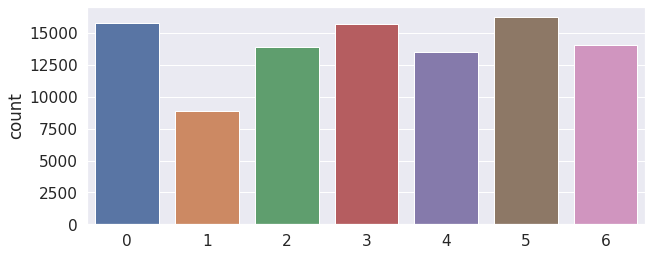

In [8]:
# Plot label distribution
plt.figure(figsize=(10,4))
sns.countplot(y)

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.5 Evaluate predictions</b></p>
</div>

**Continuous features**

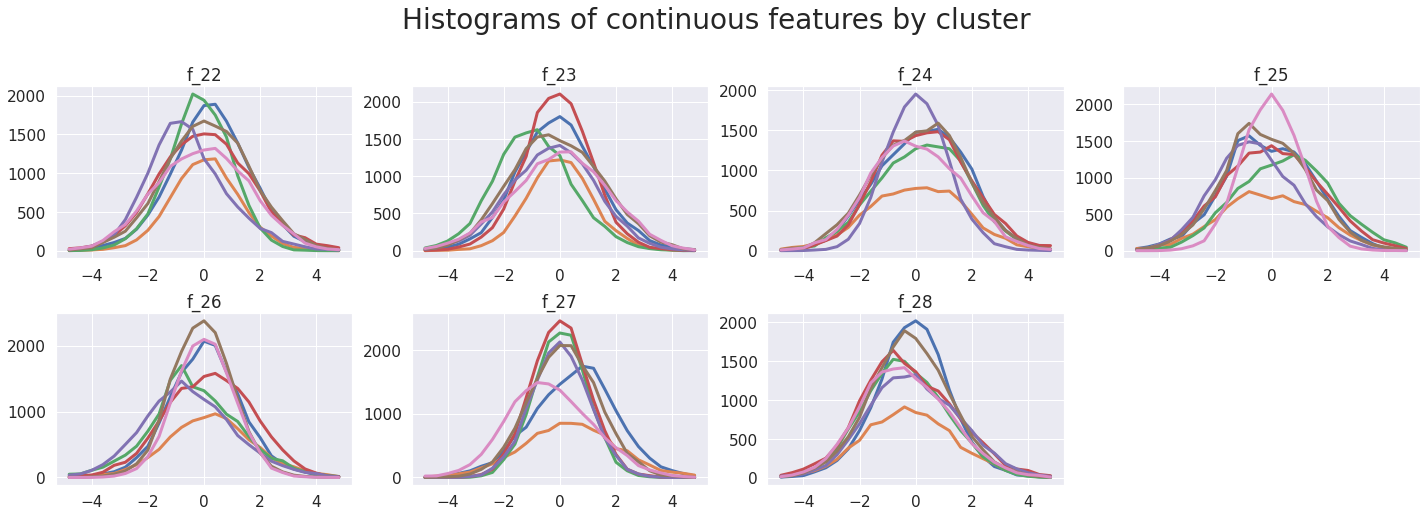

In [9]:
# From https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
fig, axs = plt.subplots(2, 4, figsize=(20, 7))
axs = axs.ravel()
float_columns = ['f_22','f_23','f_24','f_25','f_26','f_27','f_28']
for ax, f in zip(axs, float_columns):
    for i in range(7):
        h, edges = np.histogram(data[f][y == i], bins=np.linspace(-5, 5, 26))
        ax.plot((edges[:-1] + edges[1:]) / 2, h, label=f"Cluster {i}", lw=3)
    ax.set_title(f)
axs[-1].axis('off')
plt.suptitle('Histograms of continuous features by cluster', y=1.02, fontsize=28)
fig.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

**Normal Q-Q plots**

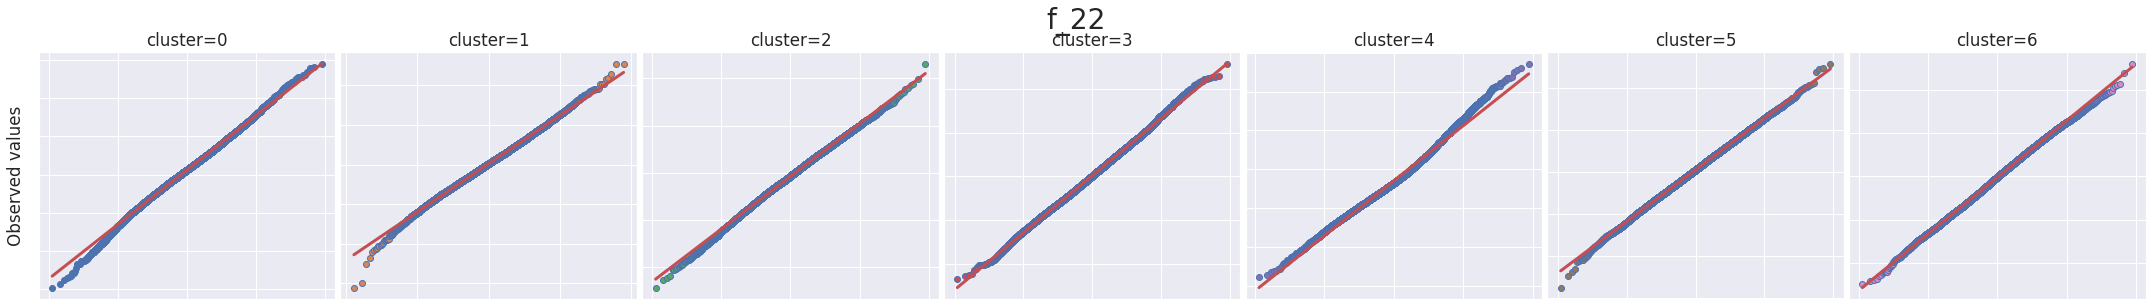

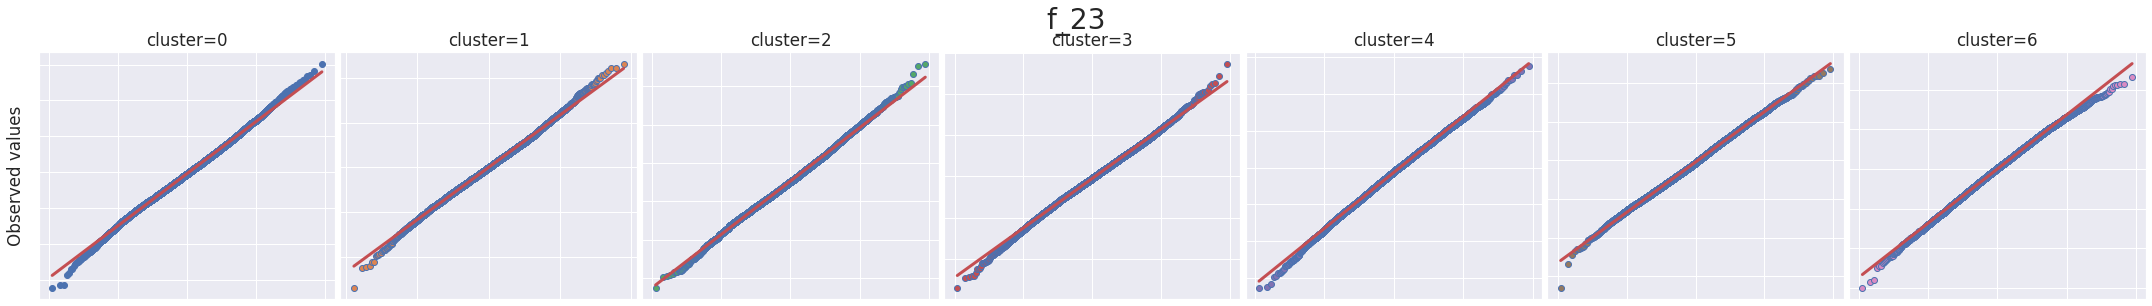

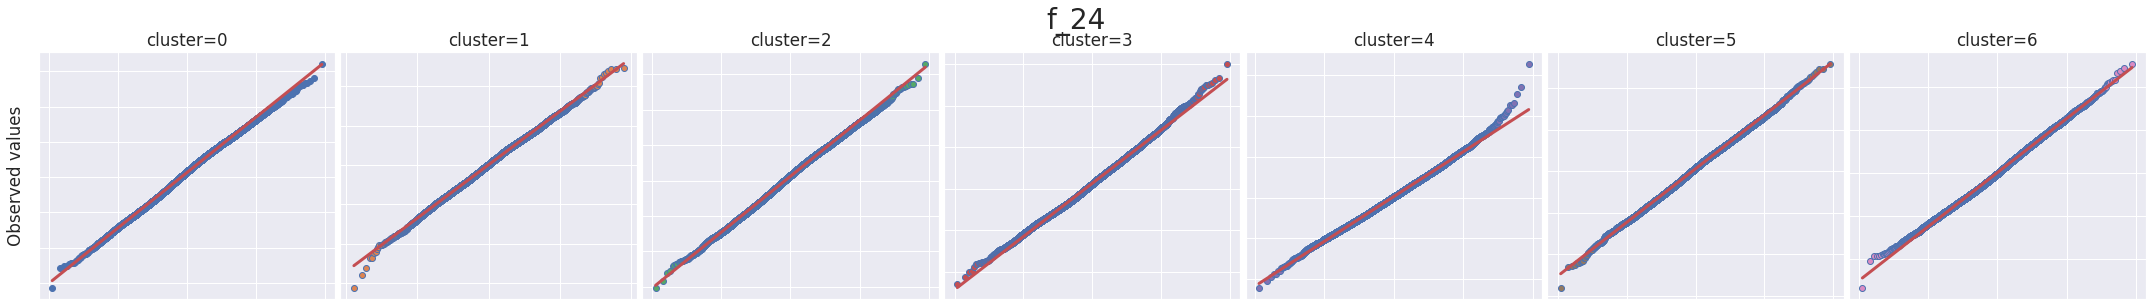

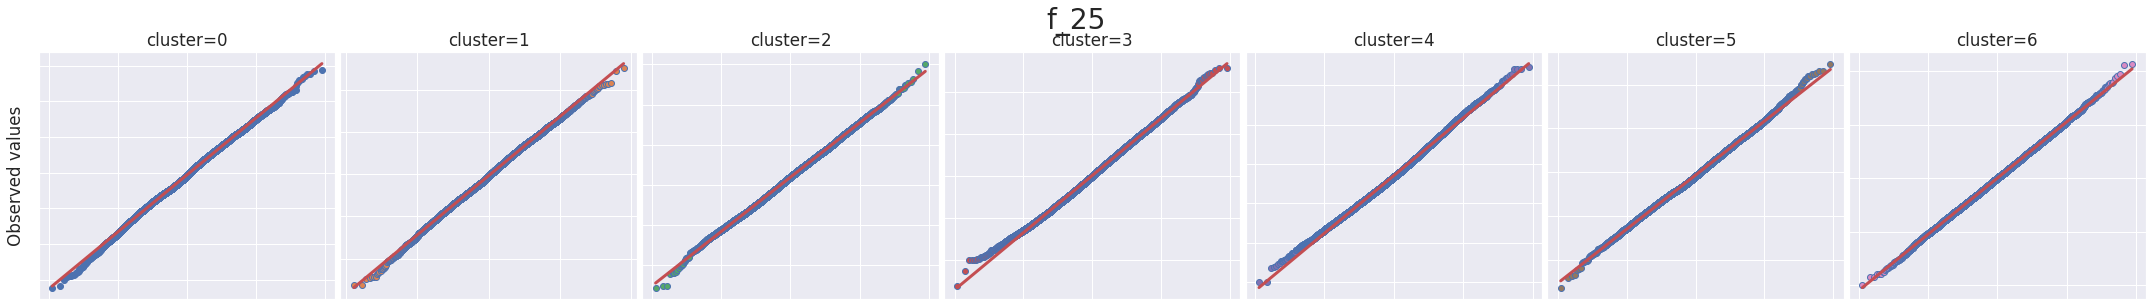

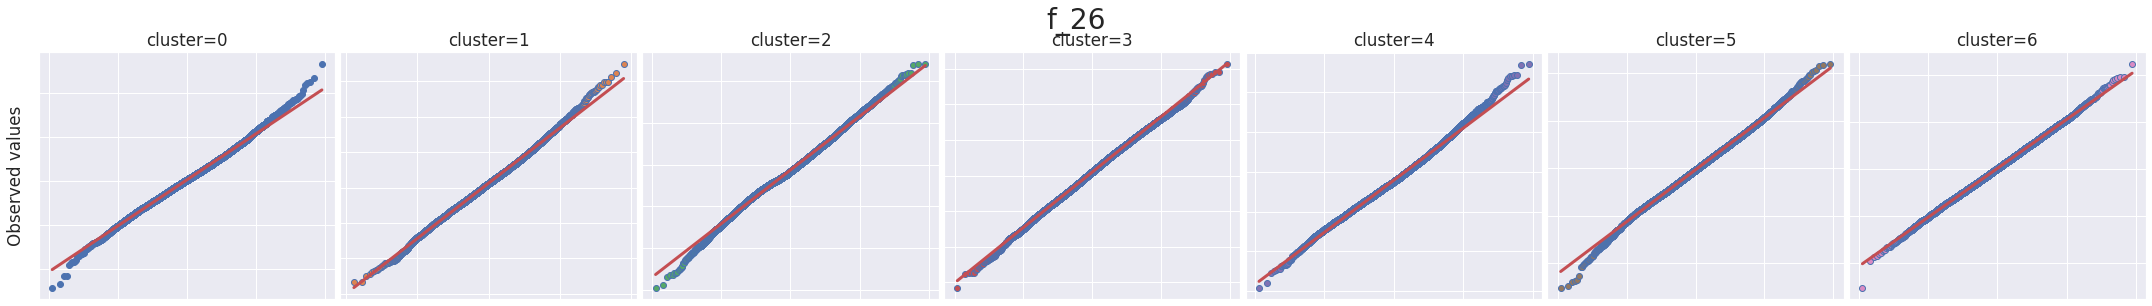

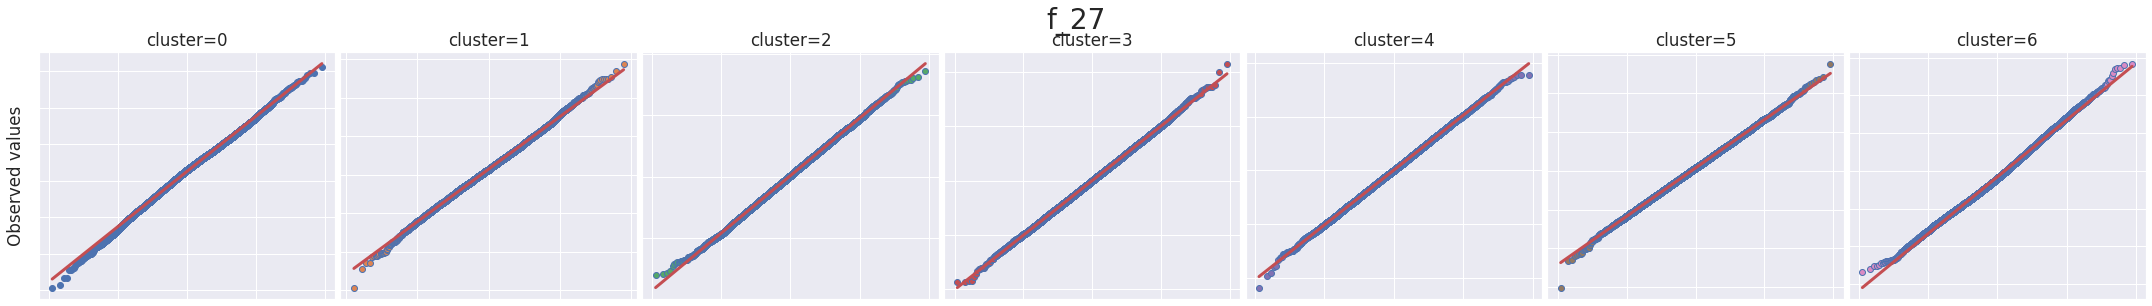

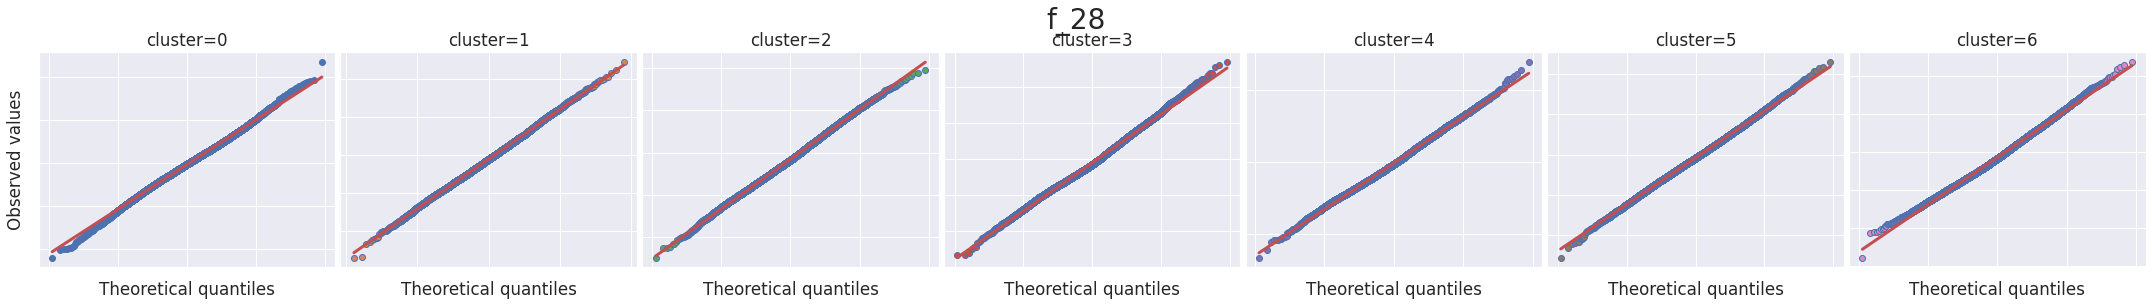

In [10]:
# Normal Q-Q plots
for i, col in enumerate(['f_22','f_23','f_24','f_25','f_26','f_27','f_28']):
    fig = plt.figure(figsize=(30,4))
    for j in range(7):
        clus = data[col][y==j]
        ax = plt.subplot(1, 7, j+1)
        stats.probplot(clus, dist='norm', plot=plt)
        
        # Aesthetics
        ax.get_lines()[0].set_markersize(6.0)
        ax.get_lines()[1].set_linewidth(3.0)
        ax.get_lines()[0].set_markerfacecolor(f'C{j}')
        ax.set_ylabel('')
        ax.set_xlabel('')
        if j==0:
            ax.set_ylabel('Observed values')
        if i==6:
            ax.set_xlabel('Theoretical quantiles')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.title(f'cluster={j}')
    fig.tight_layout(h_pad=1.0, w_pad=0.5)
    plt.suptitle(col, y=1.05, fontsize=28)
    plt.show()
    print('')

**Discrete features**

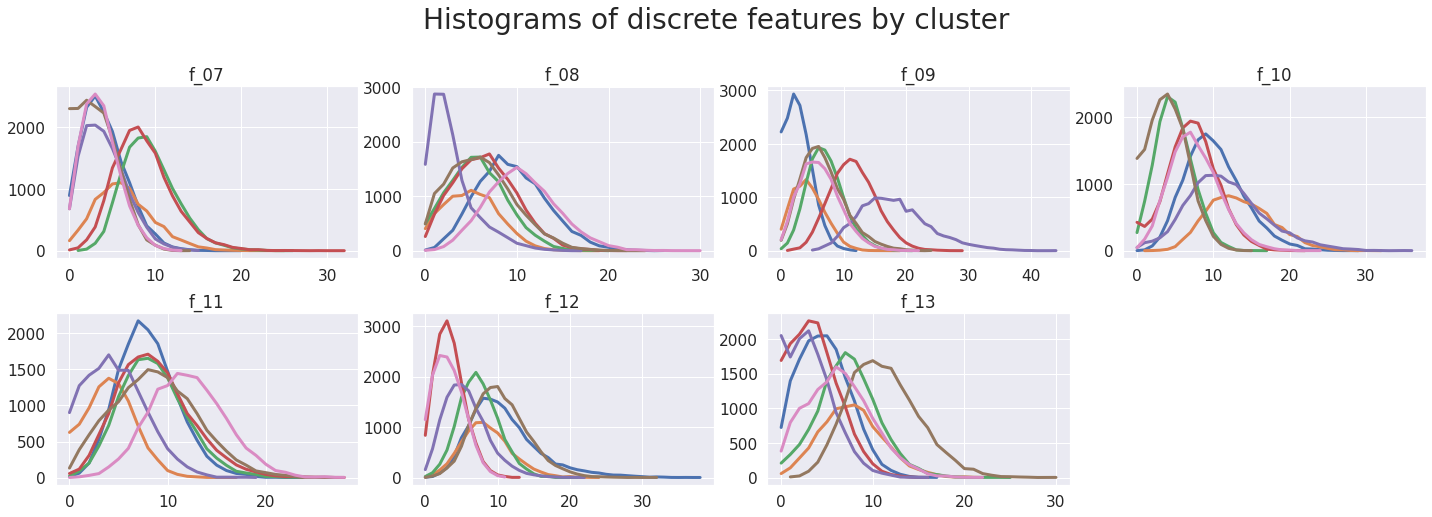

In [11]:
# From https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
prop_cycle = plt.rcParams['axes.prop_cycle']

fig, axs = plt.subplots(2, 4, figsize=(20, 7))
axs = axs.ravel()
int_columns = [col for col in data.columns if data[col].dtype == 'int']
for ax, f in zip(axs, int_columns):
    for i in range(7):
        uv, uc = np.unique(data[f][y == i], return_counts=True)
        ax.plot(uv, uc, alpha=1, color=prop_cycle.by_key()['color'][i % 10], lw=3)
    ax.set_title(f)
    #ax.legend()
axs[-1].axis('off')
plt.suptitle('Histograms of discrete features by cluster', y=1.02, fontsize=28)
fig.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

**Poisson Q-Q plots**

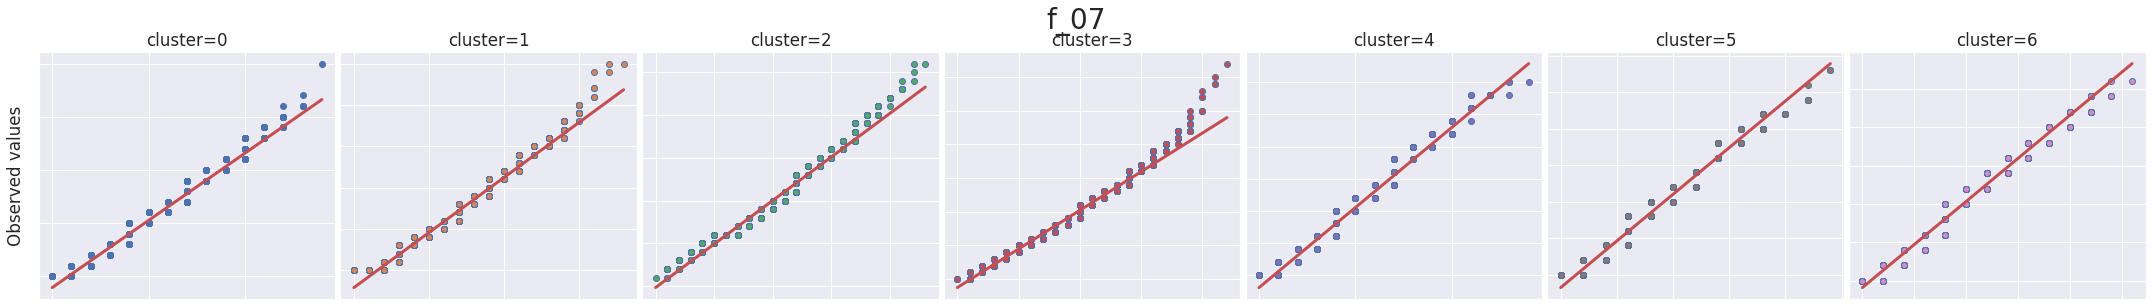

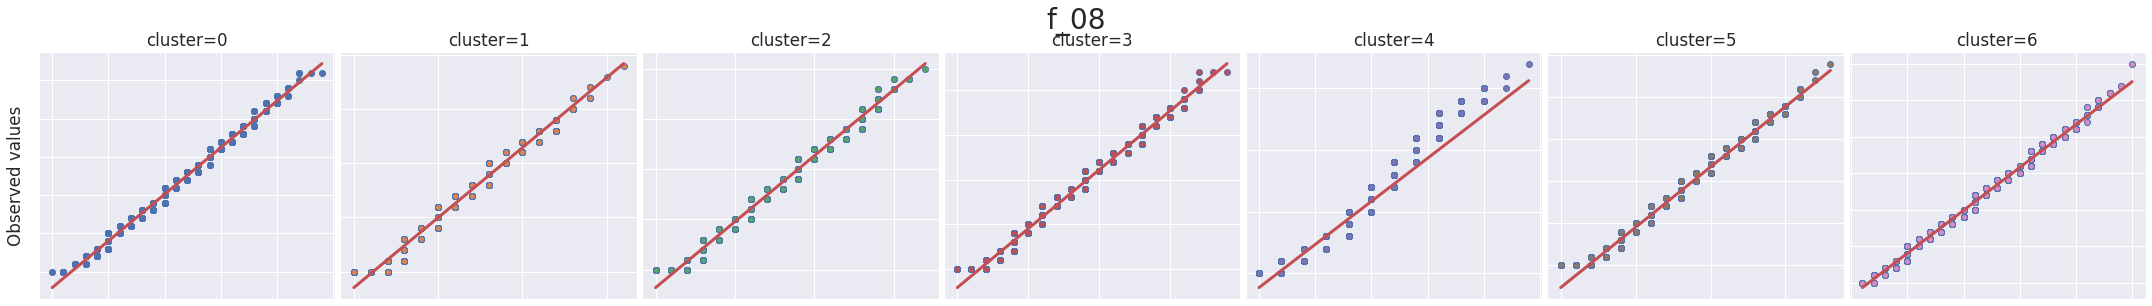

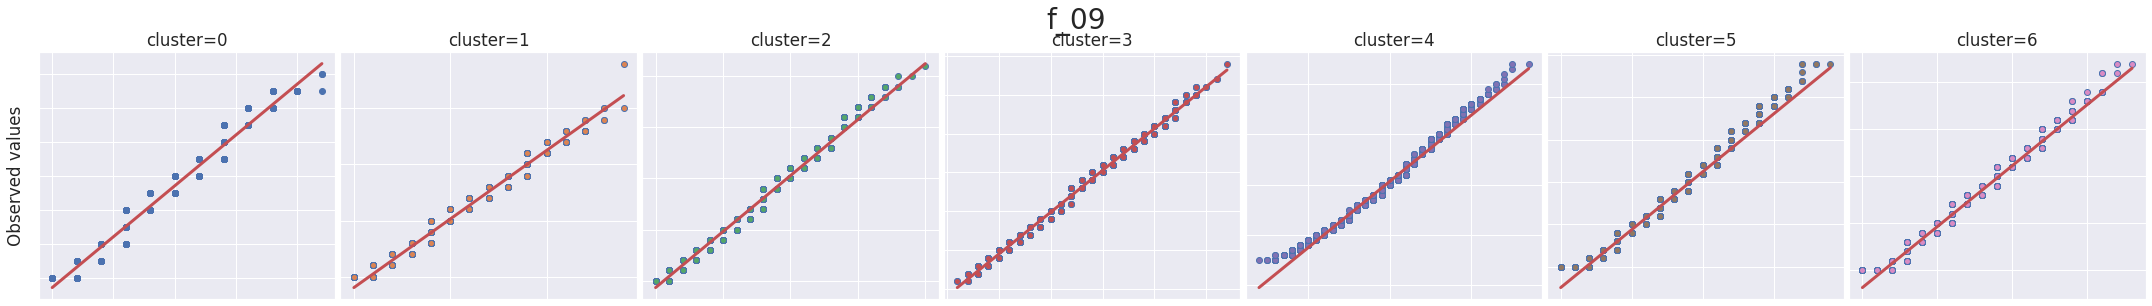

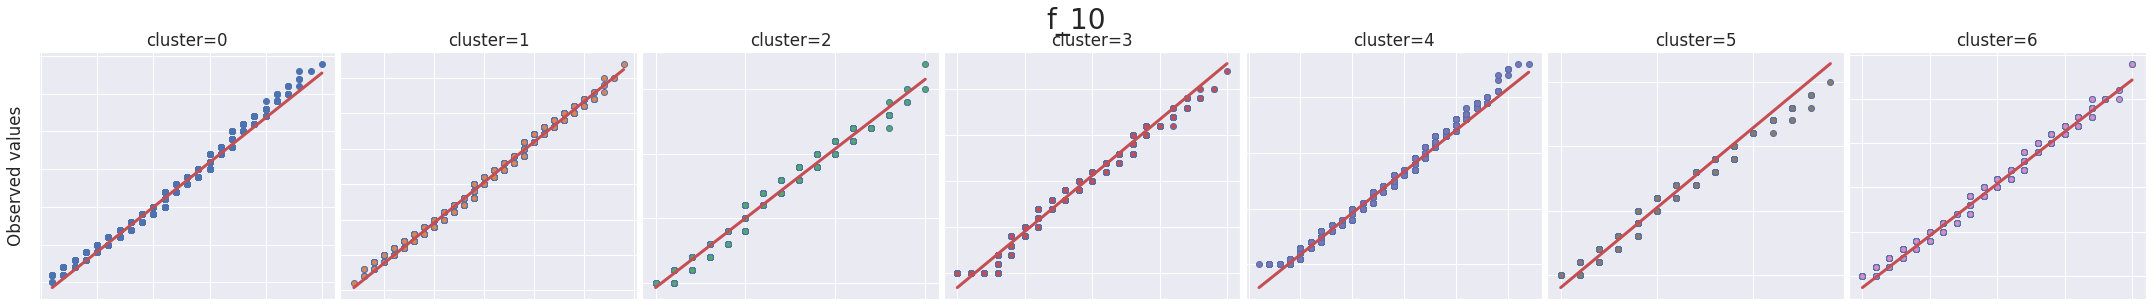

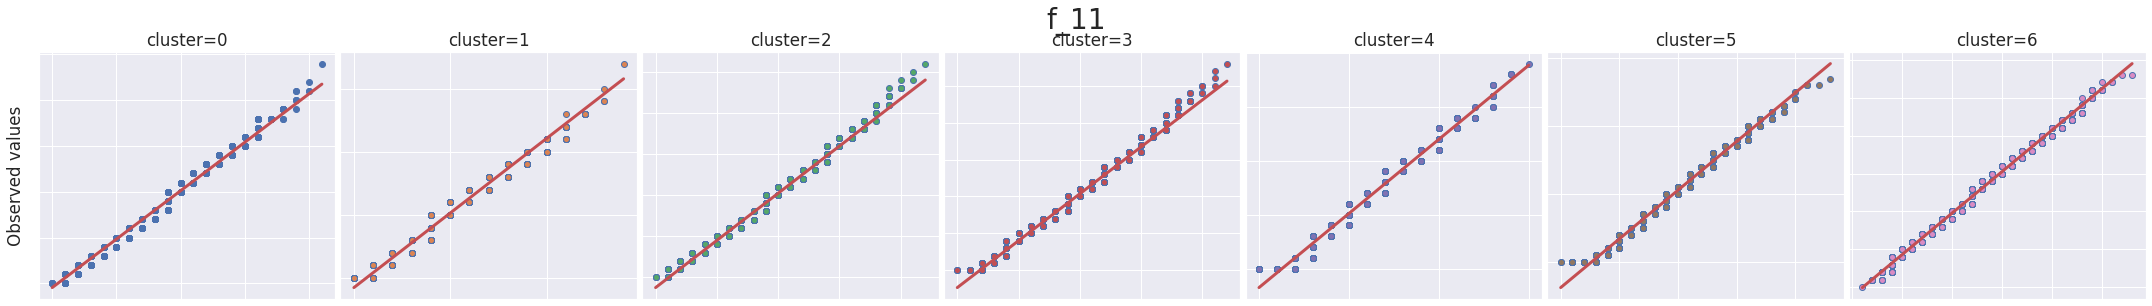

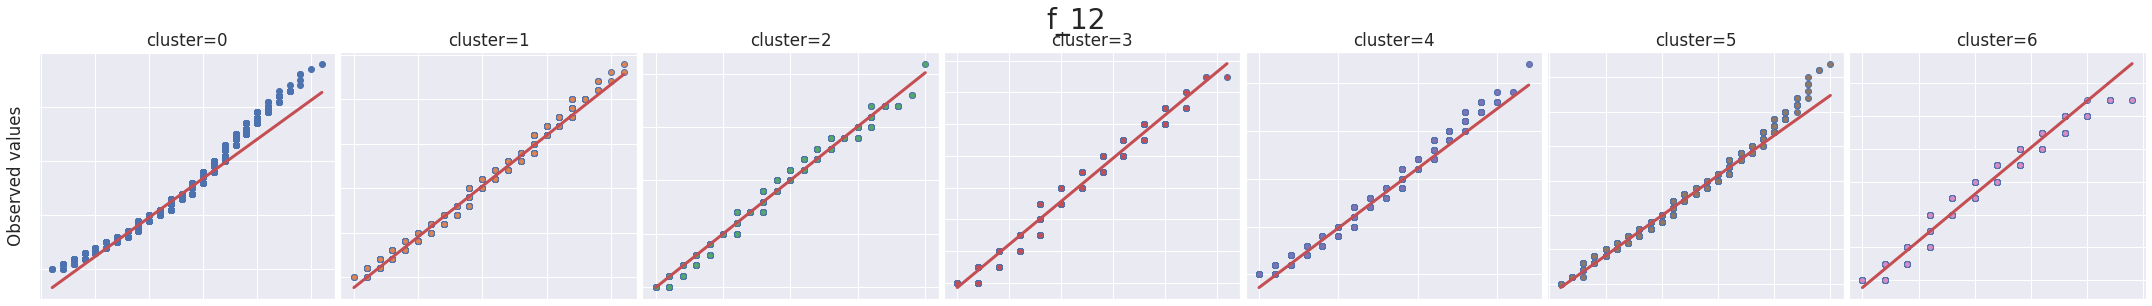

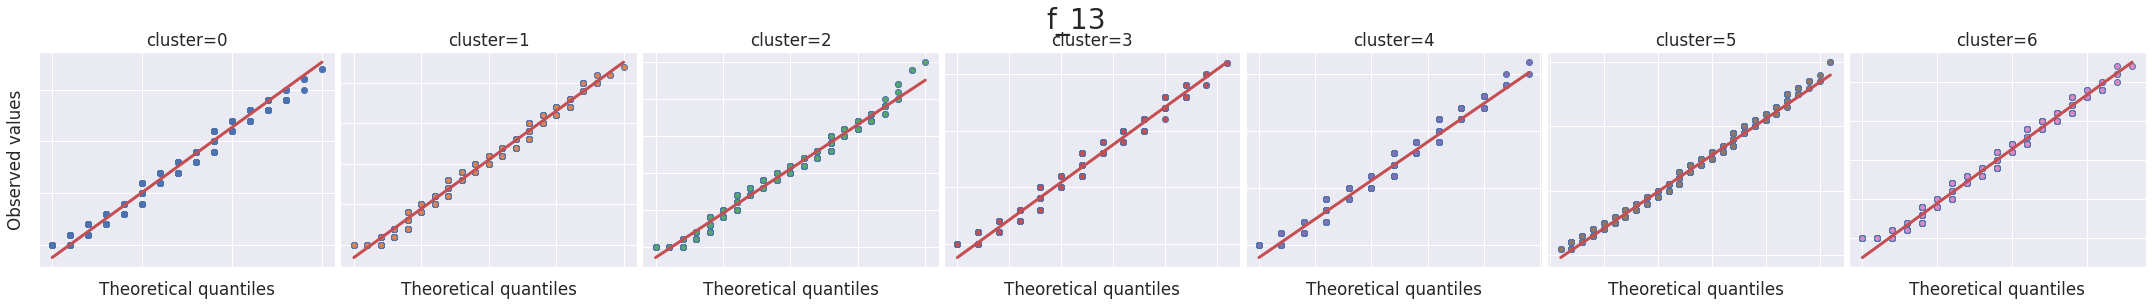

In [12]:
# Poisson Q-Q plots
for i, col in enumerate(['f_07','f_08','f_09','f_10','f_11','f_12','f_13']):
    fig = plt.figure(figsize=(30,4))
    for j in range(7):
        clus = data[col][y==j]
        mu = clus.mean()
        ax = plt.subplot(1, 7, j+1)
        stats.probplot(clus, dist='poisson', sparams=(mu,), plot=plt)
        
        # Aesthetics
        ax.get_lines()[0].set_markersize(6.0)
        ax.get_lines()[1].set_linewidth(3.0)
        ax.get_lines()[0].set_markerfacecolor(f'C{j}')
        ax.set_ylabel('')
        ax.set_xlabel('')
        if j==0:
            ax.set_ylabel('Observed values')
        if i==6:
            ax.set_xlabel('Theoretical quantiles')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.title(f'cluster={j}')
    fig.tight_layout(h_pad=1.0, w_pad=0.5)
    plt.suptitle(col, y=1.05, fontsize=28)
    plt.show()
    print('')

**PCA**

In [13]:
%%time

# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(X)

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()

CPU times: user 1.22 s, sys: 802 ms, total: 2.02 s
Wall time: 1.56 s


<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.6 Submit predictions</b></p>
</div>

In [14]:
sub = pd.read_csv('../input/tabular-playground-series-jul-2022/sample_submission.csv')
sub['Predicted'] = y
sub.to_csv('submission.csv', index=False)

# 5. Conclusion

Unfortunately, the Poisson and Hybrid Mixture Models **don't perform well** on the leaderboard. As pointed out in this [discussion post](https://www.kaggle.com/competitions/tabular-playground-series-jul-2022/discussion/337563), the discrete features often have **negative covariances** which cannot be modelled properly using the multivariate Poisson distribution we defined above. The data in general has a weird distribution and it appears to be better modelled by scalling and then using a GMM. 

Even though the PMM and HMM didn't perform well on this dataset, I am still happy to have been able to derive and implement them from scratch since there are no other implementations available online. Hopefully it can be useful to someone else in the future.

# 6. References

These will be resources I used when creating the PMM. For GMM resources see my other notebook linked right at the top. 

* [Multivariate Poisson Distribution](https://reference.wolfram.com/language/ref/MultivariatePoissonDistribution.html#:~:text=The%20multivariate%20Poisson%20distribution%20is,and%20covariance%20of%20the%20distribution.) by Wolfram.
* [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution) by Wikipedia.
* [Bivariate Poisson Distribution](https://stats.stackexchange.com/questions/108705/deriving-the-bivariate-poisson-distribution) by whuber. 
* [Univariate Poisson Mixture Model](https://www.cs.helsinki.fi/u/bmmalone/probabilistic-models-spring-2014/PoissonMixtureModels.pdf) by Brandon Malone. 